In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
csv_dir = '../my-data'
dfs_1, dfs_2 = [], []
for csv in os.listdir(csv_dir):
    df = pd.read_csv(os.path.join(csv_dir, csv), index_col=0, dtype=float)
    df.drop(columns=["0.5"], inplace=True)
    if csv.endswith('1.csv'):
        dfs_1.append(df)
    elif csv.endswith('2.csv'):
        dfs_2.append(df)

chiller_temps = [pd.concat(dfs) for dfs in zip(dfs_1, dfs_2)]
df_concat = pd.concat(chiller_temps)
df_grouped = df_concat.groupby(df_concat.index)
avg_temp = df_grouped.max()
avg_temp.drop(index=[210.0, 240.0, 270.0, 300.0, 330.0], inplace=True)
avg_temp.head(13)

,1.25,2.0,2.75,3.5,4.25,5.0,5.75,6.5,7.25
0.0,2.3703,2.1481,2.5629,3.4393,4.0825,5.6261,6.8660,7.5000,7.3835
30.0,2.3282,3.6836,4.6876,4.1669,3.7088,4.0085,5.3438,6.5479,7.3065
60.0,3.2721,3.8536,4.1946,4.8841,5.0730,4.5068,4.8249,5.6620,6.1023
90.0,2.4132,2.5751,2.9767,3.7512,4.2699,5.0396,3.8903,4.1736,6.0842
120.0,3.1701,5.0859,5.5402,5.0749,4.9000,4.7430,4.6373,4.5207,4.3112
150.0,2.9602,3.7203,4.7100,4.3392,4.1675,3.9531,3.6568,3.4943,3.3190
180.0,3.1168,3.6944,4.2351,4.5522,4.1500,3.8579,3.5080,3.2345,2.9968


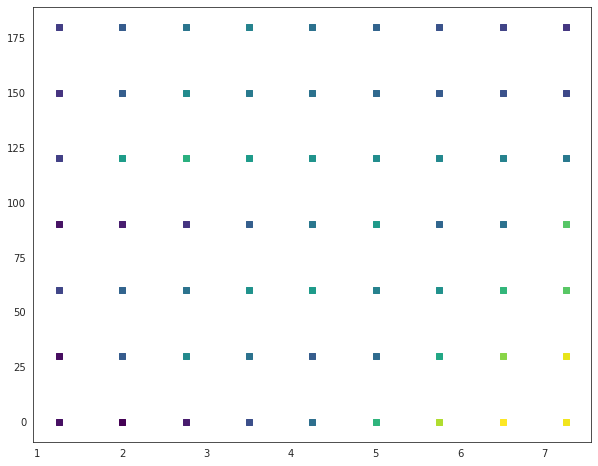

In [4]:
nx1 = 30
nx2 = 1
X1_obs = [float(i) for i in avg_temp.columns.tolist()]
X2_obs = [float(i) for i in avg_temp.index.tolist()]
x1, x2 = np.meshgrid(X1_obs, X2_obs)
x11 = sum(x1.tolist(), [])
x22 = sum(x2.tolist(), [])
# x1, x2 = np.meshgrid(np.linspace(0,360,nx1), np.linspace(0,8,nx2))
# X = np.concatenate([x1.reshape(nx1*nx2, 1), x2.reshape(nx1*nx2, 1)], 1)

# X1_obs = chiller_temp.columns.tolist()
# X2_obs = chiller_temp.index.tolist()
y_obs = sum(avg_temp.values.tolist(), [])
y_obs_norm = [float(i)/sum(y_obs) for i in y_obs]

with sns.axes_style("white"):
    plt.figure(figsize=(10,8))
    plt.scatter(x11, x22, c=y_obs, marker='s', cmap=plt.cm.viridis);

In [5]:
X_obs = np.concatenate([x1.reshape(len(x1)*len(x1[0]), 1), x2.reshape(len(x2)*len(x2[0]), 1)], axis=1)

In [6]:
RANDOM_SEED = 42
CHAINS = 4

In [7]:
with pm.Model() as polynomial_regression:
    X1 = np.asarray(x11)
    X2 = np.asarray(x22)
    
    y_obs_pm = pm.Data('y_obs_pm', y_obs)
    
    #B0 = pm.Normal('B0',0,20)
    #B1 = pm.Normal('B1',0,20)
    #B2 = pm.Normal('B2',0,20)
    #B11 = pm.Normal('B11',0,20)
    #B22 = pm.Normal('B22',0,20)
    #B12 = pm.Normal('B12',0,20)
    
    beta = pm.Normal('beta',0,20, shape=6)
    sigma = pm.HalfNormal('sigma',100)
    
    mu = beta[0] + beta[1]*X1 + beta[2]*X2 + beta[3]*X1**2 + beta[4]*X2**2 + beta[5]*X1*X2
    #mu = B0 + B1*X1 + B2*X2 + B11*X1**2 + B22*X2**2 + B12*X1*X2
    
    y_hat = pm.Normal('y_hat', mu, sigma, observed=y_obs)

In [8]:
with polynomial_regression:
    regression_trace = pm.sample(1000, tune=3000, cores=8, chains=CHAINS, random_seed=RANDOM_SEED, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 8 jobs)
NUTS: [sigma, beta]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 73 seconds.


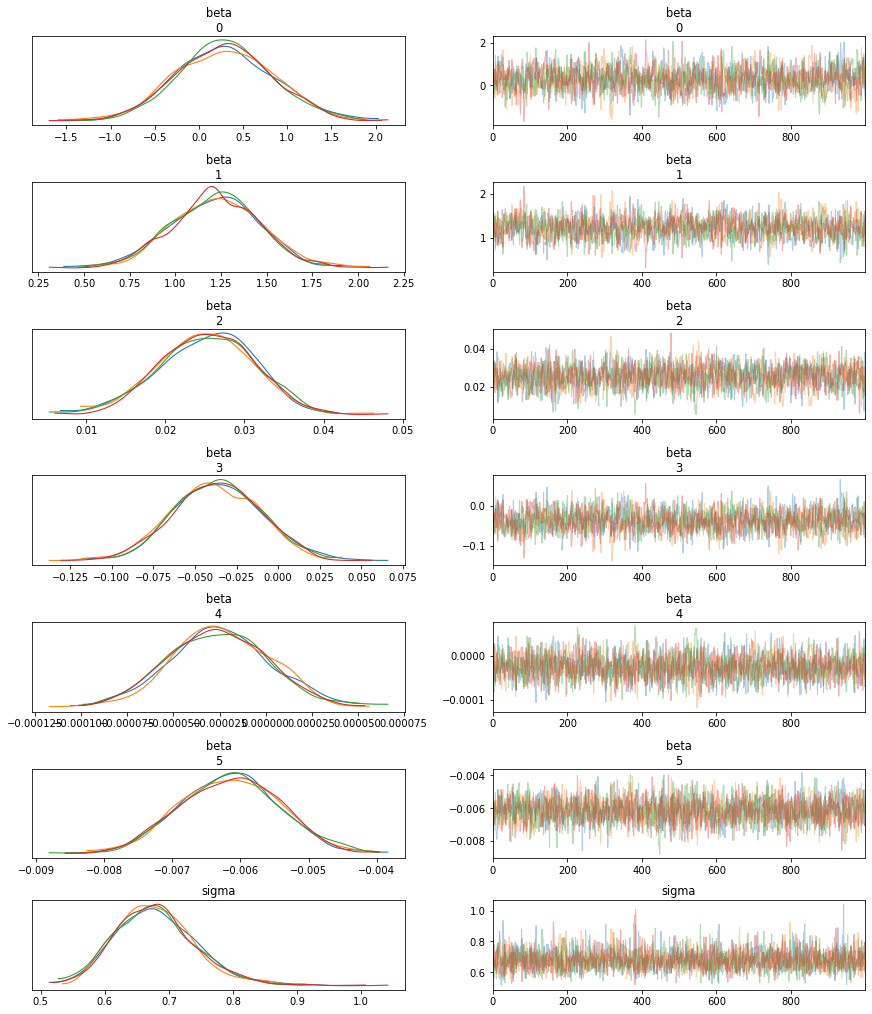

In [9]:
az.plot_trace(regression_trace, compact=False);

array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'beta\n2'}>],
       [<AxesSubplot:title={'center':'beta\n3'}>,
        <AxesSubplot:title={'center':'beta\n4'}>,
        <AxesSubplot:title={'center':'beta\n5'}>],
       [<AxesSubplot:title={'center':'sigma'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

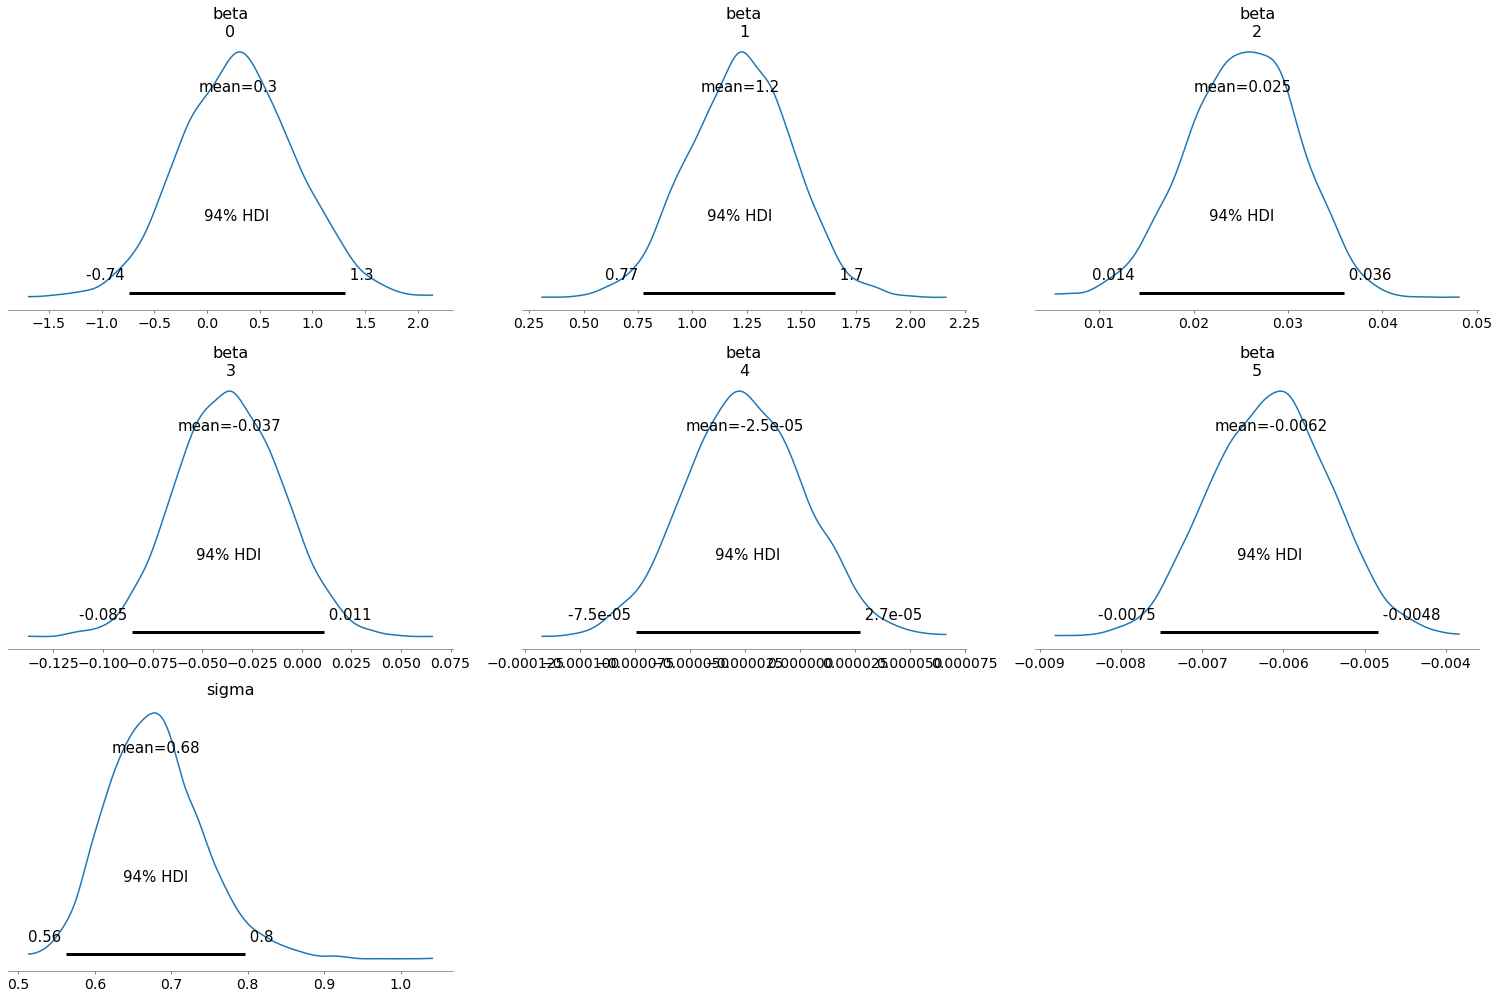

In [10]:
az.plot_posterior(regression_trace)

In [11]:
az.summary(regression_trace, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.297,0.551,-0.738,1.309,0.016,0.011,1182.726,1919.122,1.002
beta[1],1.219,0.240,0.772,1.656,0.007,0.005,1264.888,1774.848,1.001
beta[2],0.025,0.006,0.014,0.036,0.000,0.000,1397.353,1654.138,1.000
beta[3],-0.037,0.026,-0.085,0.011,0.001,0.000,1423.329,1778.026,1.001
beta[4],-0.000,0.000,-0.000,0.000,0.000,0.000,1875.617,2097.873,1.000
beta[5],-0.006,0.001,-0.008,-0.005,0.000,0.000,1788.698,2350.084,1.000
sigma,0.679,0.063,0.563,0.796,0.001,0.001,2575.293,2413.183,1.000


In [12]:
loo_1 = az.loo(regression_trace, polynomial_regression)
loo_1.loo

-67.5230341143363

In [13]:
nv = 18
nd = 14
ws = np.linspace(0.5, 10, nv)
wd = np.linspace(10, 170, nd)
t1, t2 = np.meshgrid(ws, wd)
T = np.concatenate([t1.reshape(len(t1)*len(t1[0]), 1), t2.reshape(len(t2)*len(t2[0]), 1)], axis=1)

In [14]:
n_samples = 4000

samples = []
for b0, b1, b2, b3, b4, b5 in regression_trace['beta'][:n_samples]:
    for d in wd:
        for s in ws:
            samples.append(b0 + b1*s + b2*d + b3*s**2 + b4*d**2 + b5*s*d)
            
samples_1 = np.array(samples)
samples_1 = samples_1.reshape(n_samples,252)
samples_1

array([[ 0.77817184,  1.42881068,  2.05891945, ...,  2.88746492,
         2.65409658,  2.40019816],
       [ 0.32846787,  1.07344798,  1.77692754, ...,  1.77822392,
         1.31088693,  0.80204939],
       [ 0.40856822,  1.19153114,  1.93642096, ...,  1.51643152,
         1.06988663,  0.58526865],
       ...,
       [ 0.8742737 ,  1.65837213,  2.39332235, ...,  1.17795567,
         0.59176681, -0.04357025],
       [ 1.37074119,  1.93123322,  2.47827455, ...,  2.33037512,
         2.0999408 ,  1.85605577],
       [ 0.74426869,  1.42740499,  2.08099318, ...,  2.1195935 ,
         1.73742164,  1.32570168]])

In [15]:
s_1 = samples_1.mean(axis=0).reshape(nd,nv)
sd_1 = samples_1.std(axis=0).reshape(nd,nv)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

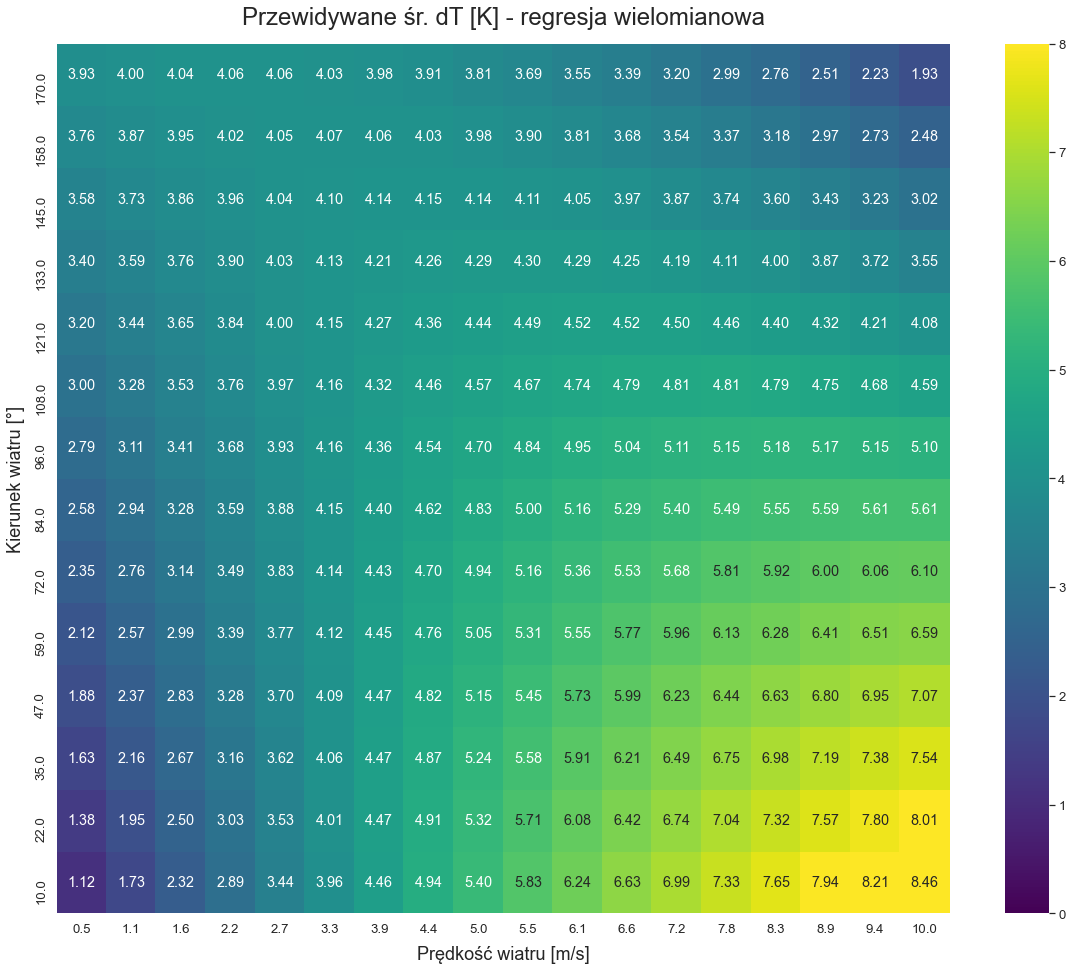

In [18]:
plt.figure(figsize=(20,16))
sns.set(font_scale=1.2)
ax = sns.heatmap(s_1, vmin=0, vmax=8, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Przewidywane śr. dT [K] - regresja wielomianowa', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)

Text(0.5, 118.5, 'Prędkość wiatru [m/s]')

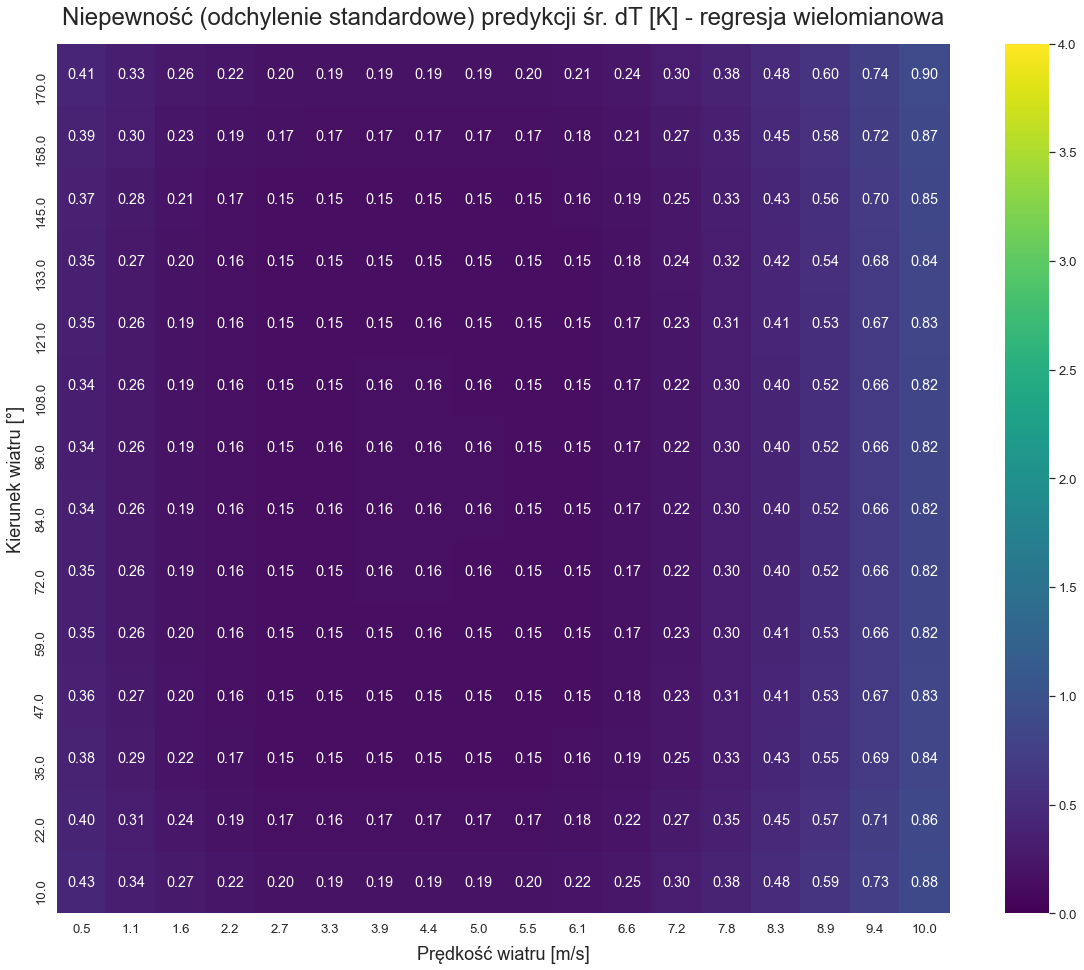

In [17]:
plt.figure(figsize=(20,16))
ax = sns.heatmap(sd_1, vmin=0, vmax=4, annot=True, fmt='.2f', cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels(wd.round())
ax.set_xticklabels(ws.round(1))
ax.set_title('Niepewność (odchylenie standardowe) predykcji śr. dT [K] - regresja wielomianowa', fontsize=24, y=1.015)
ax.set_ylabel('Kierunek wiatru [\N{DEGREE SIGN}]', fontsize=18, labelpad=10)
ax.set_xlabel('Prędkość wiatru [m/s]', fontsize=18, labelpad=10)